In [2]:
!pip install -Uqq fastbook
import fastbook

     |████████████████████████████████| 727kB 8.2MB/s 
     |████████████████████████████████| 1.0MB 22.6MB/s 
     |████████████████████████████████| 194kB 44.6MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 40kB 6.0MB/s 
     |████████████████████████████████| 92kB 10.8MB/s 
     |████████████████████████████████| 61kB 8.3MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 2.6MB 48.6MB/s 


In [3]:
from fastbook import *

In [4]:
from fastai.collab import *
from fastai.tabular.all import *

path = untar_data(URLs.ML_100k)

the data is in u.data tab seperated

In [5]:
!dir {path}

# there are a lot of files here

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [6]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None, 
                      names=['user', 'movie', 'rating', 'timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
# if we could represent user preference based on what they like as 

user1 = np.array([0.9,0.8,-0.6])

# and movies like

inception = np.array([0.98,0.9,-0.9])

# then finding a match for this combination is as simple as

(user1*inception).sum()

  # the np arrays are the latent factors
  # our goal is to learn these latent factors

2.1420000000000003

### Learning the latent factors.

1. Step 1 of this approach is to randomly initialize some parameters. These parameters will be a set of latent factors for each user and movie. 

2. Step 2 of this approach is to calculate our predictions. As we've discussed, we can do this by simply taking the dot product of each movie with each user. 

3. Step 3 is to calculate our loss. We can use any loss function that we wish; let's pick mean squared error for now



In [8]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [9]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [10]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


In [11]:
dls.classes

{'title': (#1665) ['#na#',"'Til There Was You (1997)",'1-900 (1994)','101 Dalmatians (1996)','12 Angry Men (1957)','187 (1997)','2 Days in the Valley (1996)','20,000 Leagues Under the Sea (1954)','2001: A Space Odyssey (1968)','3 Ninjas: High Noon At Mega Mountain (1998)'...],
 'user': (#944) ['#na#',1,2,3,4,5,6,7,8,9...]}

In [12]:
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5
user_factors =torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [13]:
user_factors

tensor([[-1.0827,  0.2138,  0.9310, -0.2739, -0.4359],
        [-0.5195,  0.7613, -0.4365,  0.1365,  1.3300],
        [-1.2804,  0.0705,  0.6489, -1.2110,  1.8266],
        ...,
        [ 0.8009, -0.4734, -0.8962, -0.7348, -0.0246],
        [ 0.3354, -0.8262, -0.1541,  0.4699,  0.4873],
        [ 2.4054, -0.2156, -1.4126, -0.2467,  1.0571]])

To calculate the result for a particular movie and user combination, we have to look up the index of the movie in our movie latent factor matrix and the index of the user in our user latent factor matrix; then we can do our dot product between the two latent factor vectors.

Fortunately, it turns out that we can represent look up in an index as a matrix product. The trick is to replace our indices with one-hot-encoded vectors.


In [14]:
one_hot_3 = one_hot(3, n_users).float()

In [15]:
user_factors.t() @one_hot_3

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

In [16]:
user_factors[3]

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

If we do that for a few indices at once, we will have a matrix of one-hot-encoded vectors, and that operation will be a matrix multiplication! This would be a perfectly acceptable way to build models using this kind of architecture, except that it would use a lot more memory and time than necessary. We know that there is no real underlying reason to store the one-hot-encoded vector, or to search through it to find the occurrence of the number one—we should just be able to index into an array directly with an integer. Therefore, most deep learning libraries, including PyTorch, include a special layer that does just this; it indexes into a vector using an integer, but has its derivative calculated in such a way that it is identical to what it would have been if it had done a matrix multiplication with a one-hot-encoded vector. This is called an embedding.

This is what embeddings are. We will attribute to each of our users and each of our movies a random vector of a certain length (here, n_factors=5), and we will make those learnable parameters.

### Collaborative filtering from scratch

The key idea in object-oriented programming is the class. We have been using classes throughout this book, such as DataLoader, string, and Learner.

In [17]:
class Example:
  def __init__(self, a):
    self.a = a
  def say(self, x):
    return f'Hello {self.a}, {x}.'

In Python, any method surrounded in double underscores like this is considered special. It indicates that there is some extra behavior associated with this method name. In the case of __init__, this is the method Python will call when your new object is created

In [18]:
ex = Example('sylvian')
ex.say('nice to meet you')

'Hello sylvian, nice to meet you.'

Also note that creating a new PyTorch module requires inheriting from Module.

 PyTorch already provides a Module class, which provides some basic foundations that we want to build on. So, we add the name of this superclass after the name of the class that we are defining, as shown in the following example.

The final thing that you need to know to create a new PyTorch module is that when your module is called, PyTorch will call a method in your class called forward, and will pass along to that any parameters that are included in the call. Here is the class defining our dot product model:

In [19]:
class DotProduct(Module):
  def __init__(self, n_users, n_movies, n_factors):
    self.user_factors = Embedding(n_users, n_factors)
    self.movie_factors = Embedding(n_movies, n_factors)
  
  def forward(self, x):
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    return (users * movies).sum(dim=1)

Note that the input of the model is a tensor of shape batch_size x 2, where the first column (x[:, 0]) contains the user IDs and the second column (x[:, 1]) contains the movie IDs. 

In [20]:
x,y = dls.one_batch()
x.shape

torch.Size([64, 2])

Now that we have defined our architecture, and created our parameter matrices, we need to create a Learner to optimize our model. In the past we have used special functions, such as cnn_learner

In [21]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [22]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.344786,1.279100,00:11
1,1.093332,1.109981,00:10
2,0.958258,0.990199,00:10
3,0.814234,0.894916,00:10
4,0.780714,0.882022,00:10


this is the baseline which we can improve on

first thing we need to do is to force those prediction between 0 and 5. We just need to use sigmoid_range

In [23]:
class DotProduct(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
    self.user_factors = Embedding(n_users, n_factors)
    self.movie_factors = Embedding(n_movies, n_factors)
    self.y_range = y_range
  
  def forward(self, x):
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.986799,1.005294,00:10
1,0.878134,0.918898,00:11
2,0.675850,0.875467,00:11
3,0.483372,0.877939,00:10
4,0.378927,0.881887,00:10


we need to add biases

In [24]:
class DotProductBias(Module):
  def __init__(self, n_users, n_movies, n_factors,y_range=(0,0.5) ):
    self.user_factors =  Embedding(n_users, n_factors)
    self.user_bias = Embedding(n_users, 1)
    self.movie_factors = Embedding(n_movies, n_factors)
    self.movie_bias = Embedding(n_movies, 1)
    self.y_range = y_range
  def forward(self, x):
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    res = (users * movies).sum(dim=1, keepdim=True)
    res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
    return sigmoid_range(res, *self.y_range)

In [25]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,10.533926,10.430619,00:11
1,10.453868,10.404377,00:11
2,10.472994,10.403590,00:11
3,10.510985,10.403465,00:11
4,10.475751,10.403454,00:11


As we've seen, this is a clear indication of overfitting. In this case, there is no way to use data augmentation, so we will have to use another regularization technique. One approach that can be helpful is *weight decay*.


Weight decay, or L2 regularization, consists in adding to your loss function the sum of all the weights squared. Why do that? Because when we compute the gradients, it will add a contribution to them that will encourage the weights to be as small as possible.

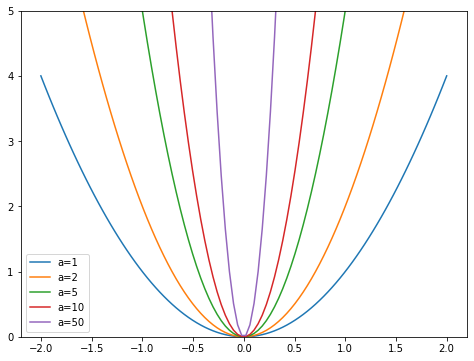

In [26]:
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50]
ys = [a * x**2 for a in a_s]
_, ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s, ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend()

So, letting our model learn high parameters might cause it to fit all the data points in the training set with an overcomplex function that has very sharp changes, which will lead to overfitting.

Limiting our weights from growing too much is going to hinder the training of the model, but it will yield a state where it generalizes better. Going back to the theory briefly, weight decay (or just wd) is a parameter that controls that sum of squares we add to our loss (assuming parameters is a tensor of all parameters):

loss_with_wd = loss + wd * (parameters **2).sum()

In [27]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,10.488676,10.441222,00:11
1,10.477038,10.407826,00:11
2,10.465181,10.406440,00:11
3,10.461014,10.406198,00:11
4,10.427763,10.406175,00:11


Creating our own embedding module

In [28]:
class T(Module):
  def __init__(self):
    self.a = torch.ones(3)
L(T().parameters())

(#0) []

In [29]:
# to create torch,ones as a paramer we have to use nn.Parameter

class T(Module):
  def __init__(self):
    self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

In [30]:
# All PyTorch modules use nn.Parameter for any trainable parameters
# which is why we haven't needed to explicitly use this wrapper up until 
class T(Module):
  def __init__(self):
    self.a  =nn.Linear(1,3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[-0.3292],
        [-0.8623],
        [ 0.0592]], requires_grad=True)]

In [31]:
type(t.a.weight)

torch.nn.parameter.Parameter

In [32]:
# we can create tensor as a parameter with random initialisation as :
def create_params(size):
  return nn.Parameter(torch.zeros(size).normal_(0,0.01))


In [33]:
class DotProductBiasParams(Module):
  def __init__(self, n_users, n_movies, nfactors, y_range=(0,5.5)):
    self.user_factors = create_params([n_users,n_factors])
    self.user_bias = create_params([n_users])
    self.movie_factors = create_params([n_movies, n_factors])
    self.movie_bias = create_params([n_movies])
    self.y_range = y_range
  
  def forward(self, x):
    users = self.user_factors[x[:,0]]
    movies = self.movie_factors[x[:,1]]
    res = (users*movies).sum(dim=1)
    res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
    return sigmoid_range(res, *self.y_range)

In [34]:
model = DotProductBiasParams(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.928835,0.948660,00:09
1,0.888645,0.883315,00:09
2,0.807825,0.849257,00:09
3,0.770519,0.840483,00:09
4,0.720767,0.839938,00:09


lets take a look at what the model has learned

In [35]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
print(idxs)

[dls.classes['title'][i] for i in idxs]

tensor([ 295,  850, 1251, 1001, 1378])


['Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Robocop 3 (1993)',
 'Mortal Kombat: Annihilation (1997)',
 'Spice World (1997)']

What it's saying is that for each of these movies, even when a user is very well matched to its latent factors (which, as we will see in a moment, tend to represent things like level of action, age of movie, and so forth), they still generally don't like it. We could have simply sorted the movies directly by their average rating, but looking at the learned bias tells us something much more interesting. It tells us not just whether a movie is of a kind that people tend not to enjoy watching, but that people tend not to like watching it even if it is of a kind that they would otherwise enjoy! 

In [36]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Close Shave, A (1995)',
 'Wrong Trousers, The (1993)',
 'L.A. Confidential (1997)',
 "Schindler's List (1993)"]

Youll like close shave even if you dont like movies that are related to the genre

It is not quite so easy to directly interpret the embedding matrices. There are just too many factors for a human to look at. But there is a technique that can pull out the most important underlying directions in such a matrix, called principal component analysis (PCA). 

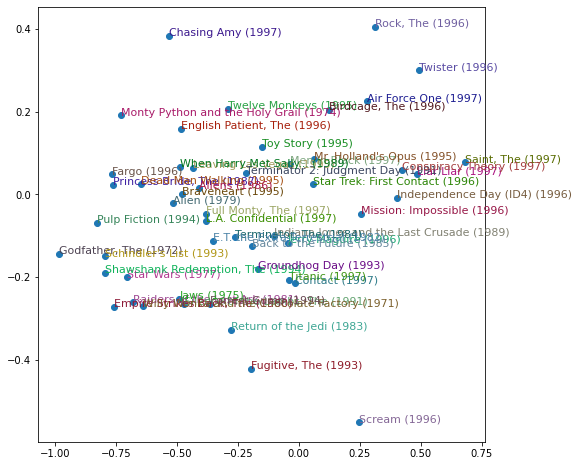

In [37]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0, fac1, fac2 = movie_pca.t()
idxs = np.random.choice(len(top_movies), 25, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(8,8))
plt.scatter(X,Y)
for i, x, y in zip(top_movies[idxs], X, Y):
  plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

using fastai.collab

In [38]:
learn = collab_learner(dls, n_factor=50, y_range=(0,5.5))
learn.fit_one_cycle(5,5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.946658,0.965206,00:12
1,0.838362,0.875717,00:15
2,0.718851,0.833586,00:12
3,0.594616,0.819008,00:12
4,0.478497,0.819555,00:11


In [39]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [40]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['L.A. Confidential (1997)',
 'Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 'Rear Window (1954)']

EMbedding distance

On a two-dimensional map we can calculate the distance between two coordinates using the formula of Pythagoras:  x2+y2−−−−−−√  (assuming that x and y are the distances between the coordinates on each axis). For a 50-dimensional embedding we can do exactly the same thing, except that we add up the squares of all 50 of the coordinate distances.

If there were two movies that were nearly identical, then their embedding vectors would also have to be nearly identical, because the users that would like them would be nearly exactly the same. There is a more general idea here: movie similarity can be defined by the similarity of users that like those movies. And that directly means that the distance between two movies' embedding vectors can define that similarity. We can use this to find the most similar movie to Silence of the Lambs:

In [41]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Pallbearer, The (1996)'

addinf an autofill functionality

In [42]:
from ipywidgets import *

def autoFill(opts=[''], val='',txt='',placehold='Please type here...',callback=False):
    opts.append('')
    def dropFunc(value):
        if (value.new in opts):
            dropClose()
            if (callable(callback)):
                callback(value) 
        text.value = value.new                
    def dropClose():
        drop.layout.visibility='hidden'
        selDropBox.layout.visibility='hidden'            
        selDropBox.layout.display='none'         
    def textFunc(value):
        matched = False
        if (len(value.new)>len(value.old)):
            if (len(value.new)>2):
                word = value.new
                out = [word]
                for mystring in opts:
                    if word.lower() in mystring.lower(): 
                        if (mystring.lower()==word.lower()):
                            matched = True
                        out.append(mystring)
                if (not matched):
                    drop.layout.visibility='visible'
                    selDropBox.layout.visibility='visible'
                    selDropBox.layout.display='flex'
                    out.append('')
                    drop.options=out 
                else:
                    dropClose()                    
        
    drop = Select(
                options=opts,
                value=val,
                rows=10,
                description=txt,
                disabled=False,
           )     
    text = Text(
                value=val,
                placeholder=placehold,
                description=txt,
                disabled=False,    
            )         
    drop.observe(dropFunc, names='value')
    text.observe (textFunc,names='value')
    selTextBox = Box([text])
    selDropBox = Box([drop], layout = Layout(display='none', top='-32px', visibility='hidden', flex_flow='column'))
    return (VBox([selTextBox, selDropBox],layout = Layout(display='flex', flex_flow='column'))) 


In [43]:

from ipywidgets import HTML, HBox

def open(value):
  show.value = value.new

options = ['ddd', 'ewr']

autofill = autoFill(options, callback=open)
show = HTML('Result will be displayed')
display(HBox([autofill, show]))

### Bootstrapping a model 
when no info is given

### Deep learning for collborative filtering

a function get_emb_sz that returns recommended sizes for embedding matrices for your data, based on a heuristic that fast.ai has found tends to work well in practice

In [44]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [45]:
class CollabNN(Module):
  def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
    self.user_factors = Embedding(*user_sz)
    self.item_factors = Embedding(*item_sz)
    self.layers = nn.Sequential(
        nn.Linear(user_sz[1]+item_sz[1], n_act),
        nn.ReLU(),
        nn.Linear(n_act, 1)
    )
    self.y_range = y_range
  
  def forward(self, x):
    embs = self.user_factors(x[:,0]), self.item_factors(x[:,1])
    x = self.layers(torch.cat(embs, dim=1))
    return sigmoid_range(x, *self.y_range)

In [46]:
model = CollabNN(*embs)

CollabNN creates our Embedding layers in the same way as previous classes in this chapter, except that we now use the embs sizes. self.layers is identical to the mini-neural net we created in <> for MNIST. Then, in forward, we apply the embeddings, concatenate the results, and pass this through the mini-neural net. Finally, we apply sigmoid_range as we have in previous models.

In [47]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5,5e-3,wd=0.01)

epoch,train_loss,valid_loss,time
0,0.944636,0.952870,00:14
1,0.914069,0.900021,00:14
2,0.852636,0.885869,00:14
3,0.815389,0.876161,00:14
4,0.769507,0.879186,00:14


In [48]:
#fastai provides this model in fastai.collab if you pass use_nn=True
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.015020,1.014081,00:18
1,0.884252,0.934120,00:18
2,0.879848,0.896547,00:18
3,0.810465,0.870086,00:18
4,0.796152,0.868160,00:18


In [49]:
learn.model

EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(944, 74)
    (1): Embedding(1665, 102)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(176, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=176, out_features=100, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=100, out_features=50, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
    (3): SigmoidRange(low=0, high=5.5)
  )
)

learn.model is an object of type EmbeddingNN. Let's take a look at fastai's code for this class:

Wow, that's not a lot of code! This class inherits from TabularModel, which is where it gets all its functionality from. In __init__ it calls the same method in TabularModel, passing n_cont=0 and out_sz=1; other than that, it only passes along whatever arguments it received.

`EmbeddingNN` includes `**kwargs` as a parameter to `__init__`. In Python `**kwargs` in a parameter list means "put any additional keyword arguments into a dict called `kwargs`. And `**kwargs` in an argument list means "insert all key/value pairs in the `kwargs` dict as named arguments here". This approach is used in many popular libraries, such as `matplotlib`, in which the main `plot` function simply has the signature `plot(*args, **kwargs)`. The [`plot` documentation](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.plot) says "The `kwargs` are `Line2D` properties" and then lists those properties.
```python
@delegates(TabularModel)
class EmbeddingNN(TabularModel):
    def __init__(self, emb_szs, layers, **kwargs):
        super().__init__(emb_szs, layers=layers, n_cont=0, out_sz=1, **kwargs)
```
We're using `**kwargs` in `EmbeddingNN` to avoid having to write all the arguments to `TabularModel` a second time, and keep them in sync. However, this makes our API quite difficult to work with, because now Jupyter Notebook doesn't know what parameters are available. Consequently things like tab completion of parameter names and pop-up lists of signatures won't work.

fastai resolves this by providing a special `@delegates` decorator, which automatically changes the signature of the class or function (`EmbeddingNN` in this case) to insert all of its keyword arguments into the signature.

In [50]:
dls

In [51]:
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


### crosstab

In [52]:
for i in ratings.head():
  print(i)

user
movie
rating
timestamp
title


In [53]:

ratings['rating'].head()

0    3
1    3
2    5
3    3
4    5
Name: rating, dtype: int64

In [54]:
print(ratings['rating'].head()[4])

# for i in range(len(ratings['user'])):
#   print(ratings[i,:]
  

5


In [58]:
#https://pbpython.com/pandas-crosstab.html
ct = pd.crosstab(ratings['user'], ratings['title'], values= ratings['rating'],aggfunc='mean')
ct.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",8 1/2 (1963),8 Heads in a Duffel Bag (1997),8 Seconds (1994),A Chef in Love (1996),Above the Rim (1994),Absolute Power (1997),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Across the Sea of Time (1995),Addams Family Values (1993),Addicted to Love (1997),"Addiction, The (1995)","Adventures of Pinocchio, The (1996)","Adventures of Priscilla, Queen of the Desert, The (1994)","Adventures of Robin Hood, The (1938)","Affair to Remember, An (1957)","African Queen, The (1951)",Afterglow (1997),"Age of Innocence, The (1993)",Aiqing wansui (1994),Air Bud (1997),Air Force One (1997),"Air Up There, The (1994)",Airheads (1994),Akira (1988),Aladdin (1992),Aladdin and the King of Thieves (1996),Alaska (1996),Albino Alligator (1996),Alice in Wonderland (1951),Alien (1979),Alien 3 (1992),Alien: Resurrection (1997),Aliens (1986),All About Eve (1950),All Dogs Go to Heaven 2 (1996),All Over Me (1997),All Things Fair (1996),Alphaville (1965),Amadeus (1984),Amateur (1994),"Amazing Panda Adventure, The (1995)",American Buffalo (1996),American Dream (1990),"American President, The (1995)",American Strays (1996),"American Werewolf in London, An (1981)","American in Paris, An (1951)",Amistad (1997),Amityville 1992: It's About Time (1992),Amityville 3-D (1983),"Amityville Curse, The (1990)","Amityville Horror, The (1979)",Amityville II: The Possession (1982),Amityville: A New Generation (1993),Amityville: Dollhouse (1996),Amos & Andrew (1993),An Unforgettable Summer (1994),Anaconda (1997),Anastasia (1997),Andre (1994),Angel Baby (1995),Angel and the Badman (1947),Angel on My Shoulder (1946),Angela (1995),Angels and Insects (1995),Angels in the Outfield (1994),Angus (1995),Anna (1996),Anna Karenina (1997),Anne Frank Remembered (1995),Annie Hall (1977),Another Stakeout (1993),Antonia's Line (1995),Aparajito (1956),"Apartment, The (1960)",Apocalypse Now (1979),Apollo 13 (1995),"Apostle, The (1997)","Apple Dumpling Gang, The (1975)",April Fool's Day (1986),Apt Pupil (1998),"Aristocats, The (1970)",Army of Darkness (1993),Around the World in 80 Days (1956),"Arrival, The (1996)",Arsenic and Old Lace (1944),As Good As It Gets (1997),Assassins (1995),"Assignment, The (1997)","Associate, The (1996)",Audrey Rose (1977),August (1996),Austin Powers: International Man of Mystery (1997),"Awfully Big Adventure, An (1995)",Ayn Rand: A Sense of Life (1997),B*A*P*S (1997),B. Monkey (1998),Babe (1995),"Baby-Sitters Club, The (1995)",Babyfever (1994),"Babysitter, The (1995)",Back to the Future (1985),Backbeat (1993),Bad Boys (1995),Bad Company (1995),Bad Girls (1994),Bad Moon (1996),Bad Taste (1987),"Ballad of Narayama, The (Narayama Bushiko) (1958)",Balto (1995),Bananas (1971),"Band Wagon, The (1953)",Barb Wire (1996),Barbarella (1968),Barcelona (1994),Basic Instinct (1992),"Basketball Diaries, The (1995)",Basquiat (1996),Bastard Out of Carolina (1996),Batman & Robin (1997),Batman (1989),Batman Forever (1995),Batman Returns (1992),Baton Rouge (1988),Bean (1997),"Beans of Egypt, Maine, The (1994)",Beat the Devil (1954),"Beautician and the Beast, The (1997)",Beautiful Girls (1996),Beautiful Thing (1996),Beauty and the Beast (1991),Beavis and Butt-head Do America (1996),Bed of Roses (1996),Bedknobs and Broomsticks (1971),Before Sunrise (1995),Before and After (1996),Before the Rain (Pred dozhdot) (1994),Being Human (1993),Being There (1979),"Believers, The (1987)",Belle de jour (1967),Ben-Hur (1959),Benny & Joon (1993),Bent (1997),Best Men (1997),Best of the Best 3: No Turning Back (1995),Better Off Dead... (1985),"Beverly Hillbillies, The (1993)",Beverly Hills Cop III (1994),Beverly Hills Ninja (1997),"Bewegte Mann, Der (1994)",Beyond Bedlam (1993),Beyond Rangoon (1995),Bha

### list dot product

In [59]:
a = [1,2,3]
b = [2,3,4]
d_p = 0
for i in range(len(a)):
  d_p += a[i] * b[i]

print(d_p)

20


In [62]:
learn.model

EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(944, 74)
    (1): Embedding(1665, 102)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(176, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=176, out_features=100, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=100, out_features=50, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
    (3): SigmoidRange(low=0, high=5.5)
  )
)